# Notes on the Methods and Formulas

### Parameters
Parameters can be set in `configs.parameters.json`, for example:
```json
{
    "mc_horizon": 100,
    "mc_paths": 10000,
    "var_percentile": 0.1
}
```

#### The Graph (Compound-v2)
Used for current information on Compound. Total borrows, total supply, exchange rate, collateral factor and so on. 
Api at `src.the_graph_api.TheGraphAPI`. 

#### Coingecko (Historical Prices)
Use file: `data/coingecko_prices.csv`

Created by download script `download_historical_prices.py`. The script has a runtime of ~1h, because it sends about 600 requests to coingecko. The free API allows 10-50 requests per minute, so I use a sleep of 6 seconds to never send more than 10 requests per minute. 
Api at `src.coingecko_api.CoingeckoAPI`. 

Time window: `2022-11-21` to `2022-11-20`

Should be updated if gets too old compared to the timestamp of data from The Graph. 

### Volatility and Simulation of Trajectories
Calculated from the historical prices timeseries. Standard deviation of the log-returns. The log is used, because for the Monte Carlo method we model the price path by a Brownian Motion / Weiner Process, where the log-returns follow a Normal Distribution with $\mu=0$ and $\sigma=vol$. 

Implementation: `src.measures.calc_volatility`, `src.measures.monte_carlo_simulation`

### Value at Risk 
For the Value at Risk, I handled the protocol like a portfolio. Then got the distribution of `mc_paths` simulated returns, for `mc_horizon` days in the future. Then I looked at the "risk" percentile `var_percentile`, which gives a value of expected loss to that probability. A detailed description can be found further down, in the VaR-section. 
Result: 
> There is a 10% chance that the portfolio will have a return of less than 0.7510 within 100 days. (Return of 1 means same value as at beginning, >1 gain, <1 loss.)

### Runtime
The use of numpy and matrix multiplication keep the runtime low. On my machine (Intel MacBook Pro), the Monte Carlo Simulation of 10.000 * 17 paths for 100 days horizon only took 10 sec. 
Also the `calc_supply/borrow_value_usd` functions use matrix multiplication and return instantly (output 10.000 * 17).

What takes time is to download the historical prices, this is why the download code is excluded and here we load the prices from a csv.


In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import json

from src.the_graph_api import TheGraphAPI

PRICES_FILE = Path.cwd().joinpath("data", "coingecko_prices.csv")
PARAMS_FILE = Path.cwd().joinpath("configs", "parameters.json")


In [2]:
# get current Compound Borrows from The Graph

tg_api = TheGraphAPI()
borrows = tg_api.get_compound_borrows()

col_dtypes = {
    "underlyingSymbol":str,
    "underlyingName":str, 
    "totalBorrows":float,	
    "totalSupply":float,
    "collateralFactor":float,	
    "exchangeRate":float,
    "underlyingPriceUSD":float,	
    "blockTimestamp":int,
    }
borrows_df = pd.DataFrame(borrows)
borrows_df = borrows_df.apply(lambda c: c.astype(col_dtypes[c.name]))
borrows_df

,underlyingSymbol,underlyingName,collateralFactor,exchangeRate,totalBorrows,totalSupply,underlyingPriceUSD,blockTimestamp
0,USDP,Pax Dollar,0.000,0.020195,1.973789e+04,1.473193e+06,1.000000,1669192775
1,TUSD,TrueUSD,0.000,0.020554,5.487941e+06,3.924373e+08,1.000000,1669211087
2,REP,Reputation,0.000,0.020041,5.590882e+01,5.470486e+04,6.961100,1667094731
3,UNI,Uniswap,0.750,0.020300,4.302789e+05,2.186814e+08,5.397000,1669213103
4,USDC,USD//C,0.855,0.022680,2.519339e+08,2.940456e+10,1.000000,1669217507
5,SUSHI,SushiToken,0.700,0.020471,6.630032e+05,1.403794e+08,1.181746,1669213271
6,ETH,Ether,0.825,0.020076,1.385436e+04,1.826039e+07,1165.880000,1669215515
7,DAI,Dai Stablecoin,0.835,0.022106,1.703084e+08,1.767047e+10,1.000137,1669214519
8,BAT,Basic Attention Token,0.650,0.020676,4.446289e+05,7.200996e+09,0.226898,1669210835
9,COMP,Compound,0.650,0.020414,1.125086e+04,3.064798e+07,38.004375,1669213019


Have two entries for `DAI` and `wBTC` each... only keep the bigger one for now
```
{
  "underlyingSymbol": "DAI",
  "underlyingName": "Dai Stablecoin",
  "borrowRate": "0.0233026004452608",
  "totalBorrows": "211524161.923877439677332104",
  "collateralFactor": "0.835",
  "underlyingPriceUSD": "1.000773",
  "blockTimestamp": 1669045535,
  "accrualBlockNumber": 16019369
},
{
  "underlyingSymbol": "DAI",
  "underlyingName": "Dai Stablecoin v1.0 (DAI)",
  "borrowRate": "0.0501467542606656",
  "totalBorrows": "240.64852988575940222",
  "collateralFactor": "0",
  "underlyingPriceUSD": "6.210826",
  "blockTimestamp": 1668979619,
  "accrualBlockNumber": 16013904
},
....
{
  "underlyingSymbol": "WBTC",
  "underlyingName": "Wrapped BTC",
  "borrowRate": "0.0206864728473312",
  "totalBorrows": "0.39387562",
  "collateralFactor": "0.7",
  "underlyingPriceUSD": "15929.996902",
  "blockTimestamp": 1669001867,
  "accrualBlockNumber": 16015751
},
{
  "underlyingSymbol": "WBTC",
  "underlyingName": "Wrapped BTC",
  "borrowRate": "0.0221761103560704",
  "totalBorrows": "152.21575285",
  "collateralFactor": "0.7",
  "underlyingPriceUSD": "16182.771321",
  "blockTimestamp": 1669043411,
  "accrualBlockNumber": 16019192
},
```

In [3]:
borrows_df = borrows_df.sort_values(by=["underlyingSymbol", "totalBorrows"], ascending=False).reset_index(drop=True)
borrows_df = borrows_df.drop_duplicates(subset=["underlyingSymbol"])
borrows_df = borrows_df.sort_values(by=["underlyingSymbol"]).reset_index(drop=True)
borrows_df

,underlyingSymbol,underlyingName,collateralFactor,exchangeRate,totalBorrows,totalSupply,underlyingPriceUSD,blockTimestamp
0,AAVE,Aave Token,0.730,0.020307,7.521716e+03,7.696865e+05,57.527957,1669215131
1,BAT,Basic Attention Token,0.650,0.020676,4.446289e+05,7.200996e+09,0.226898,1669210835
2,COMP,Compound,0.650,0.020414,1.125086e+04,3.064798e+07,38.004375,1669213019
3,DAI,Dai Stablecoin,0.835,0.022106,1.703084e+08,1.767047e+10,1.000137,1669214519
4,ETH,Ether,0.825,0.020076,1.385436e+04,1.826039e+07,1165.880000,1669215515
5,FEI,Fei USD,0.000,0.020136,2.496479e+03,8.882565e+04,0.997575,1667774747
6,LINK,ChainLink Token,0.790,0.020171,2.485211e+04,3.453725e+07,6.413532,1669210835
7,REP,Reputation,0.000,0.020041,5.590882e+01,5.470486e+04,6.961100,1667094731
8,SUSHI,SushiToken,0.700,0.020471,6.630032e+05,1.403794e+08,1.181746,1669213271
9,TUSD,TrueUSD,0.000,0.020554,5.487941e+06,3.924373e+08,1.000000,1669211087


### Monte Carlo Simulation
- Calculate Volatilties
- Simulate Price Paths

In [4]:
from src.measures import calc_volatility, monte_carlo_simulation

with open(PARAMS_FILE) as f:
    params = json.load(f)
    
# load historical prices from coingecko (used scrip `download_historica_prices.ipynb` to prepare data)
prices = pd.read_csv(PRICES_FILE)
symbols = sorted(prices["symbol"].unique())

# calculate volatilities
vols = {}
for symbol in symbols:
    p = prices[prices["symbol"] == symbol]["price"].values
    vols[symbol] = calc_volatility(p)

print(vols)

{'aave': 0.07464626572283103, 'bat': 0.06004059637910412, 'comp': 0.06638834095565146, 'dai': 0.002007655992637203, 'eth': 0.06422278659986509, 'fei': 0.02851061647386272, 'link': 0.07018952104224735, 'rep': 0.07171938656321616, 'sushi': 0.09514300836715131, 'tusd': 0.00282056858179138, 'uni': 0.0697395479254225, 'usdc': 0.0021574718617547875, 'usdp': 0.0043466418878502005, 'usdt': 0.0019460020558690057, 'wbtc': 0.04429704461003883, 'yfi': 0.06864343781384731, 'zrx': 0.0728031524419769}


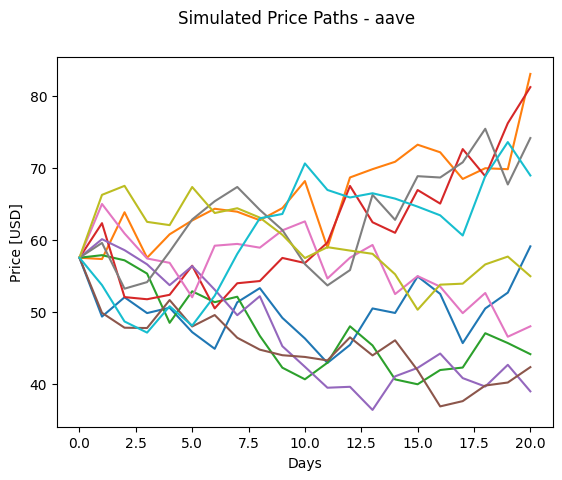

In [5]:
# plot example of Monte Carlo Paths (aave)
from src.measures import simulate_path
from src.plots import plot_mc_paths
from matplotlib import pyplot as plt

symbol = "aave"
price = borrows_df[borrows_df["underlyingSymbol"] == symbol.upper()]["underlyingPriceUSD"].iloc[0]
paths = [simulate_path(price, vols[symbol], horizon=20) for _ in range(10)]

fig = plot_mc_paths(symbol, paths)
plt.show()

In [6]:
# Simulate Monte Carlo Paths for all Symbols
mc_paths = {}
for symbol in symbols:
    price = borrows_df[borrows_df["underlyingSymbol"] == symbol.upper()]["underlyingPriceUSD"].iloc[0]
    mc_paths[symbol] = monte_carlo_simulation(price, vols[symbol], params["mc_horizon"], params["mc_paths"])

mc_prices = pd.DataFrame(mc_paths).T

print(f"For each asset simulated {params['mc_paths']} paths with time horizon of {params['mc_horizon']} days.")
print(f"Showing 10 example states:")
mc_prices[mc_prices.columns.tolist()[:10]]

For each asset simulated 10000 paths with time horizon of 100 days.
Showing 10 example states:


,0,1,2,3,4,5,6,7,8,9
aave,91.186735,49.690920,80.240570,16.776600,35.011606,65.966234,63.719897,176.000131,40.026042,172.687219
bat,0.235803,0.310562,0.822233,0.287713,0.205037,0.178787,0.279381,0.144179,0.176558,1.007628
comp,34.253292,33.113429,88.370745,19.877210,61.555204,77.221908,34.678845,37.157684,9.229411,57.242321
dai,0.969795,0.964942,1.010555,0.959253,1.008856,0.978436,0.969868,0.981147,0.966404,0.989553
eth,612.423413,723.353588,376.107856,2283.287392,729.224018,2396.753848,1616.476845,918.518619,498.895902,1432.121142
fei,1.107830,1.351707,0.927340,1.210375,1.013547,0.969091,0.923505,1.824036,1.005041,1.225369
link,16.979445,3.443972,5.136558,9.863320,4.085239,10.235921,7.454643,7.630261,10.654187,4.206477
rep,7.032437,4.317384,5.452803,8.587628,4.531792,6.529483,13.389392,5.086751,4.538517,7.537390
sushi,1.511115,0.734826,0.416323,0.281123,0.684667,2.206449,0.442463,0.566529,0.236475,1.232657
tusd,0.960529,0.964296,1.009427,1.011222,1.018116,0.987924,1.037514,0.995862,1.014255,0.962665


# Calculate Value of Borrows and Supplies

- value of cTokens in USD: `amount_cToken * exchange_rate * price_usd`
- value of Supply: `supply_value * collateralFactor`
- value of Borrow: `borrow_value`

## VaR
For the Value at Risk, I handled the protocol like a portfolio. The current value $V(t_{0})$ of the portfolio is:

$V(t_{0}) = \sum_{assets} (supply\_value(t_{0}) - borrow\_value(t_{0}))$

Then the N paths with horizon $h$ are simulated for each asset and we get N potential values of the portfolio in the future. 
(same calculatian as before, only with simulated `price_usd`)

$V_{k}(t_{h}) = \sum_{assets} (supply\_value(t_{h}) - borrow\_value(t_{h}))$

From this we can calculate N returns ($R_k = V_{k}(t_{h})/ V(t_{0}), k=1,...,N$). And look at the distribution of the returns $R_k$.

The VaR is then defined as the .....



In [7]:
from src.measures import calc_borrow_value_usd, calc_supply_value_usd

borrows_df["borrowValue"] = calc_borrow_value_usd(
    n_ctoken=borrows_df["totalBorrows"].values, 
    exchange_rate=borrows_df["exchangeRate"].values, 
    prices=borrows_df["underlyingPriceUSD"].values
)

borrows_df["supplyValue"] = calc_supply_value_usd(
    n_ctoken=borrows_df["totalSupply"].values, 
    exchange_rate=borrows_df["exchangeRate"].values, 
    collateral_factor=borrows_df["collateralFactor"].values,
    prices=borrows_df["underlyingPriceUSD"].values
)

print(f"Overall Supply Value USD: {borrows_df['supplyValue'].sum()} (with collateralFactor)")
print(f"Overall Borrow Value USD: {borrows_df['borrowValue'].sum()}")
borrows_df[["underlyingSymbol", "totalSupply", "totalBorrows", "supplyValue", "borrowValue", 
            "underlyingPriceUSD", "collateralFactor", "exchangeRate"]]

Overall Supply Value USD: 1504430101.6768572 (with collateralFactor)
Overall Borrow Value USD: 13958415.112196185


,underlyingSymbol,totalSupply,totalBorrows,supplyValue,borrowValue,underlyingPriceUSD,collateralFactor,exchangeRate
0,AAVE,7.696865e+05,7.521716e+03,6.563856e+05,8.786972e+03,57.527957,0.730,0.020307
1,BAT,7.200996e+09,4.446289e+05,2.195841e+07,2.085896e+03,0.226898,0.650,0.020676
2,COMP,3.064798e+07,1.125086e+04,1.545549e+07,8.728774e+03,38.004375,0.650,0.020414
3,DAI,1.767047e+10,1.703084e+08,3.262145e+08,3.765343e+06,1.000137,0.835,0.022106
4,ETH,1.826039e+07,1.385436e+04,3.526097e+08,3.242774e+05,1165.880000,0.825,0.020076
5,FEI,8.882565e+04,2.496479e+03,0.000000e+00,5.014699e+01,0.997575,0.000,0.020136
6,LINK,3.453725e+07,2.485211e+04,3.529675e+06,3.215017e+03,6.413532,0.790,0.020171
7,REP,5.470486e+04,5.590882e+01,0.000000e+00,7.799562e+00,6.961100,0.000,0.020041
8,SUSHI,1.403794e+08,6.630032e+05,2.377212e+06,1.603918e+04,1.181746,0.700,0.020471
9,TUSD,3.924373e+08,5.487941e+06,0.000000e+00,1.127990e+05,1.000000,0.000,0.020554


### How would the Monte Carlo simulated prices affect the supply and borrow vlaues?

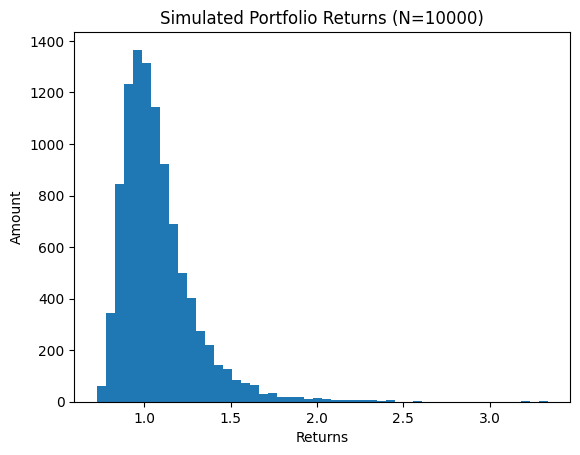

In [8]:

from src.plots import plot_returns_histogram

mc_borrow_values = calc_borrow_value_usd(
    n_ctoken=borrows_df["totalBorrows"].values, 
    exchange_rate=borrows_df["exchangeRate"].values, 
    prices=mc_prices.values
)
mc_supply_values = calc_supply_value_usd(
    n_ctoken=borrows_df["totalSupply"].values, 
    exchange_rate=borrows_df["exchangeRate"].values, 
    collateral_factor=borrows_df["collateralFactor"].values,
    prices = mc_prices.values
)

# calculate simulated returns of portfolio
original_value = borrows_df["supplyValue"].sum() - borrows_df["borrowValue"].sum()
simulated_values = (mc_supply_values.sum(axis=0) - mc_borrow_values.sum(axis=0))
returns = simulated_values / original_value


fig = plot_returns_histogram(returns, params['mc_paths'])


In [9]:
# return at the percentile (params["var_percentile"]):

var_critical_return = np.percentile(returns, q=params["var_percentile"])
print(f"There is a {int(params['var_percentile']*100)}% chance that the portfolio will have a return of less than {var_critical_return:.4f} within {params['mc_horizon']} days.")
print("Return of 1 means same value as at beginning, >1 gain, <1 loss.")

There is a 10% chance that the portfolio will have a return of less than 0.7453 within 100 days.
Return of 1 means same value as at beginning, >1 gain, <1 loss.


#### To Discuss:
- "For each price trajectory, measure the maximum insolvency of Compound."
- When asset is twice in graph list (wbtc, dai) only take the one with bigger borrows, drop the other.
- Exchange rate and collateral factor don't change?